# Exercise 2: FIR or IIR filters

$\textbf{Use the FIR or IIR filters to control the noise amplification in the differentiation.}$ <br> 
Select filter type, order and application (recursive vs convolution) as you think is most appropriate. You can use a non-causal approach to avoid phase lag, and you are free to manipulate the boundaries in any way you consider appropriate. <br> 
Comment briefly on what are the main challenges.

In [1]:
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, get_window, firwin
from scipy.signal.windows import general_hamming
%matplotlib inline

In [2]:
def Diff_1st_order(x,y):
    """ 
    Compute derivatives with first order backward difference approximation:
    y'(xi) = (y(xi)−y(xi−1)) / Δx 
    y''(xi) = (y(xi)−2y(xi−1)+y(xi-2) / Δx^2 
    For the first point (firsts 2 for the 2nd order derivative), 
    The forward difference approximation, that mirrors the expression above, 
    is considered 
    """
    
    N = x.shape[0]
    
    delta_x = np.empty(N)
    y_prime = np.empty(N) # 1st order derivative
    y_prime2 = np.empty(N) # 2nd order derivative
    # Forward first order differencing approx 
    delta_x[0] = x[1] - x[0]
    y_prime[0] = (y[1] - y[0]) / delta_x[0]
    y_prime2[0] = (y[2] - 2*y[1] + y[0]) / delta_x[0]**2
    # Backward first order differencing approx 
    for i in range(1, N):
        delta_x[i] = x[i] - x[i-1]
        y_prime[i] = (y[i] - y[i-1]) / delta_x[i]
        if i == 1:
            y_prime2[i] = (y[i+2] - 2*y[i+1] + y[i]) / delta_x[i]**2
        else:
            y_prime2[i] = (y[i] - 2*y[i-1] + y[i-2]) / delta_x[i]**2
            
    return y_prime, y_prime2

def Diff_2nd_order(x,y):
    """ 
    Compute derivatives with second order central difference approximation:
    y'(xi) = (y(xi+1)−y(xi−1)) / 2Δx 
    y''(xi) = (y(xi+1)−2y(xi)+y(xi-1) / Δx^2 
    The derivatives for the 2 points at the edge, is computed with the forward
    differencing at the left and the backwards one on the right.
    Forward:
    y'(xi) = (-y(xi+2)+4y(xi+1)-3y(xi)) / 2Δx 
    y''(xi) = (-y(xi+3)+4y(xi+2)-5y(xi+1)+2y(xi)) / Δx^2
    Backward:
    y'(xi) = (y(xi-2)-4y(xi-1)+3y(xi)) / 2Δx 
    y''(xi) = (-y(xi-3)+4y(xi-2)-5y(xi-1)+2y(xi)) / Δx^2
    """
    
    N = x.shape[0]
    
    delta_x = np.empty(N)
    # y_prime = np.gradient(y, x, edge_order=2) # 1st order derivative
    y_prime = np.empty(N) # 1st order derivative
    y_prime2 = np.empty(N) # 2nd order derivative
    
    # Forward first order differencing approx 
    delta_x[0] = x[1] - x[0]
    y_prime[0] = (-y[2] + 4*y[1] - 3*y[0]) / (2*delta_x[0])
    y_prime2[0] = (-y[3] + 4*y[2] - 5*y[1] + 2*y[0]) / delta_x[0]**2
    # Central second order differencing approx 
    for i in range(1, N):
        delta_x[i] = x[i] - x[i-1]
        if i == N-1:
            y_prime[i] = (3*y[i] - 4*y[i-1] + y[i-2]) / (2*delta_x[i])
            y_prime2[i] = (-y[i-3] + 4*y[i-2] - 5*y[i-1] + 2*y[i]) / delta_x[i]**2
        else:
            y_prime[i] = (y[i+1] - y[i-1]) / (2*delta_x[i])
            y_prime2[i] = (y[i+1] - 2*y[i] + y[i-1]) / delta_x[i]**2
    
    return y_prime, y_prime2

In [3]:
columns = ['Time','ODS_raw']
n = 500
data_raw = pd.read_excel('Signal_raw092.xlsx', 
                         header=None, skiprows=n+1, names=columns)
x, y = np.array(data_raw.Time), np.array(data_raw['ODS_raw'])
y_prime_1st, y_prime2_1st = Diff_1st_order(x,y) # 1st order schemes
y_prime_2nd, y_prime2_2nd = Diff_2nd_order(x,y) # 2nd order schemes

dt = 0.01 #s
fs = 1/dt # Hz
Nt = x.shape[0]


* $\textbf{IIR filtering}$ <br>
$ y_n = \frac{1}{a_0} \left[ \sum_{j=1}^{N-1} b_j x_{n-j} - \sum_{k=0}^{N-1} a_k y_{n-k} \right] $ <br>
IIR filters usually require fewer coefficients, are faster and require less memory space with respect to FIR filters. <br>
Their main disadvantage is their nonlinear phase response and the possibility to become unstable, due to the presence of non zero poles in their transfer function.<br>

* $\textbf{FIR filtering}$ <br>
$ y_i = \sum_{k=0}^{N-1} b_k x_{i-k} $ <br>
FIR filters can achieve linear phase response and pass a signal without phase distortion and they are intrinsically stable since they have no poles. <br>
As drawback, they need a larger number of coefficients respect to IIR filters. For this reason they require more memory and are slower.

`````{admonition} Tip
:class: tip
As seen during the SP classes, filtering a signal with FIR filters lead to phase lag. To address this problem we can apply the filter twice (once on the filtered and flipped signal). <br>
This would lead to BC problems both at the start and the end of the signal. This problem is adressed in the pre-implemented function "filtfilt"
`````

## FIR filtering with windowing approach

* $\textbf{Cut-off frequency}$ has been chosen to be 2 Hz

* FIR filters of order 100, 200, 300 are tested

In [4]:
f_c = 2 #Hz Cut-off frequency

N_O=100 # this is the order of the filter
h_impulse_100 = firwin(N_O, f_c/fs*2, window='hamming')
N_O=200 
h_impulse_200 = firwin(N_O, f_c/fs*2, window='hamming') 
N_O=300 
h_impulse_300 = firwin(N_O, f_c/fs*2, window='hamming') 

```{note}
Different windows lead to slightly different results. Hann lead to little overshoot 
```

In [5]:
n_f = Nt
dtheta= 2*np.pi/n_f                                                          
        
# angular discretization in -pi, pi:
theta_n_2=np.linspace(0,Nt-1, Nt)*dtheta-np.pi    

sys_100 = signal.TransferFunction(h_impulse_100, 1, dt=1)
w_FIR_100, mag_FIR_100, phase_FIR_100 = sys_100.bode(w=theta_n_2)

sys_200 = signal.TransferFunction(h_impulse_200, 1, dt=1)
w_FIR_200, mag_FIR_200, phase_FIR_200 = sys_200.bode(w=theta_n_2)

sys_300 = signal.TransferFunction(h_impulse_300, 1, dt=1)
w_FIR_300, mag_FIR_300, phase_FIR_300 = sys_300.bode(w=theta_n_2)

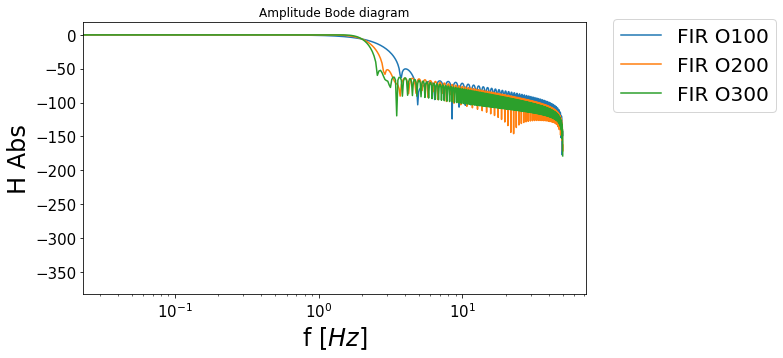

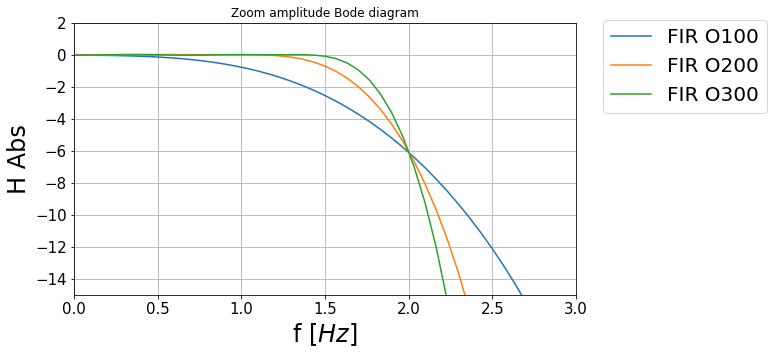

In [6]:
fig, ax = plt.subplots(figsize=(9,5))
plt.semilogx(w_FIR_100/np.pi*fs/2,mag_FIR_100,label='FIR O100')
plt.semilogx(w_FIR_200/np.pi*fs/2,mag_FIR_200,label='FIR O200')
plt.semilogx(w_FIR_300/np.pi*fs/2,mag_FIR_300,label='FIR O300')
plt.legend(fontsize=20)
plt.xlabel('f $[Hz]$',fontsize=24)
plt.ylabel('H Abs',fontsize=24)
plt.title('Amplitude Bode diagram')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor=(1.4, 1.05), fontsize=20)    
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
plt.plot(w_FIR_100/np.pi*fs/2,mag_FIR_100,label='FIR O100')
plt.plot(w_FIR_200/np.pi*fs/2,mag_FIR_200,label='FIR O200')
plt.plot(w_FIR_300/np.pi*fs/2,mag_FIR_300,label='FIR O300')
plt.legend(fontsize=20)
plt.xlabel('f $[Hz]$',fontsize=24)
plt.ylabel('H Abs',fontsize=24)
plt.xlim([0, 3])
plt.ylim([-15,2])
plt.grid()
plt.title('Zoom amplitude Bode diagram')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor=(1.4, 1.05), fontsize=20)     
plt.show()

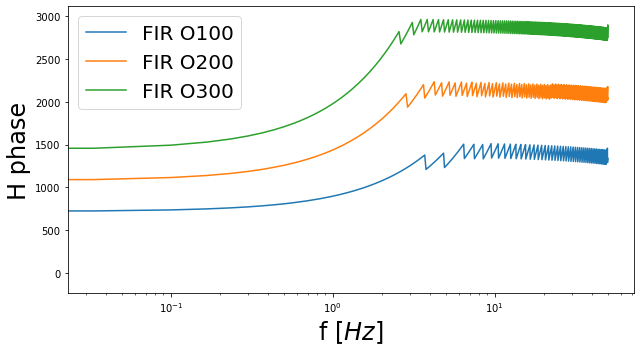

In [7]:
# The plot in the classic log vs decibel form are the following:
fig, ax = plt.subplots(figsize=(9,5)) 
plt.semilogx(w_FIR_100/np.pi*fs/2,phase_FIR_100,label='FIR O100')
plt.semilogx(w_FIR_200/np.pi*fs/2,phase_FIR_200,label='FIR O200')
plt.semilogx(w_FIR_300/np.pi*fs/2,phase_FIR_300,label='FIR O300')
plt.legend(fontsize=20)
plt.xlabel('f $[Hz]$',fontsize=24)
plt.ylabel('H phase',fontsize=24)
plt.tight_layout()
plt.show()

In [8]:
y_filt_filt_100=signal.filtfilt(h_impulse_100,1,y)
y_filt_filt_200=signal.filtfilt(h_impulse_200,1,y)
y_filt_filt_300=signal.filtfilt(h_impulse_300,1,y)

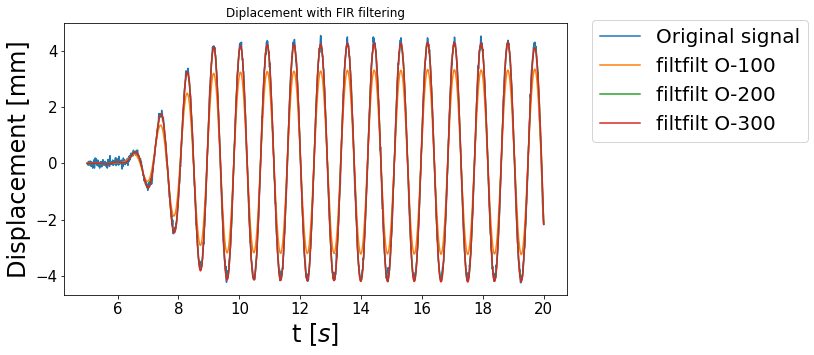

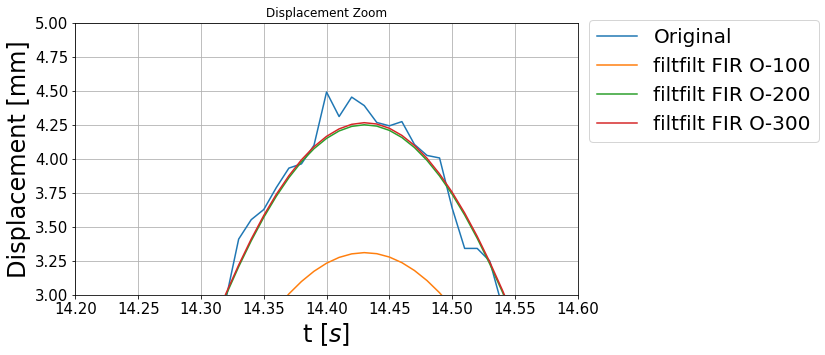

In [9]:
fig, ax = plt.subplots(figsize=(9,5)) 
plt.plot(x,y,label='Original signal')
plt.plot(x,y_filt_filt_100,label='filtfilt O-100')
plt.plot(x,y_filt_filt_200,label='filtfilt O-200')
plt.plot(x,y_filt_filt_300,label='filtfilt O-300')
plt.legend(fontsize=20)
plt.xlabel('t $[s]$',fontsize=24)
plt.ylabel('Displacement [mm]',fontsize=24)
plt.title('Diplacement with FIR filtering')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor=(1.5, 1.05), fontsize=20)     
plt.show()

fig, ax = plt.subplots(figsize=(9,5)) 
plt.plot(x,y,label='Original')
plt.plot(x,y_filt_filt_100,label='filtfilt FIR O-100')
plt.plot(x,y_filt_filt_200,label='filtfilt FIR O-200')
plt.plot(x,y_filt_filt_300,label='filtfilt FIR O-300')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('t $[s]$',fontsize=24)
plt.ylabel('Displacement [mm]',fontsize=24)
plt.xlim([14.2, 14.6])
plt.ylim([3, 5])
plt.grid()
plt.title('Displacement Zoom')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor=(1.5, 1.05), fontsize=20)      
plt.show()

The use of the 'filtfilt' function solves the problem of boundary conditions and phase delay. <br>
The FIR filter of order 100 results in a decrease in signal amplitude. <br>
The filters of order 200 and 300 have very similar performance. The filter of order 200 is chosen because it is faster and less expensive in terms of memory.

## IIR filtering with Butterworth filter

* $\textbf{Cut-off frequency}$ has been chosen to be 2 Hz

* IIR filters of order 3, 5, 7, 9 has been tested

In [10]:
f_c_IIR = 2 #Hz
b3, a3 = signal.butter(3, f_c_IIR, 'lp', analog=False,fs=fs) 
sys = signal.TransferFunction(b3, a3, dt=1) 
# Note that the result is in db by default !
w3, mag3, phase3 = sys.bode(w=theta_n_2) 

b5, a5 = signal.butter(5, f_c_IIR, 'lp', analog=False,fs=fs)
sys = signal.TransferFunction(b5, a5, dt=1) 
# Note that the result is in db by default !
w5, mag5, phase5 = sys.bode(w=theta_n_2) 

b7, a7 = signal.butter(7, f_c_IIR, 'lp', analog=False,fs=fs) 
sys = signal.TransferFunction(b7, a7, dt=1) 
# Note that the result is in db by default !
w7, mag7, phase7 = sys.bode(w=theta_n_2) 

b9, a9 = signal.butter(9, f_c_IIR, 'lp', analog=False,fs=fs) 
sys = signal.TransferFunction(b9, a9, dt=1) 
# Note that the result is in db by default !
w9, mag9, phase9 = sys.bode(w=theta_n_2) 

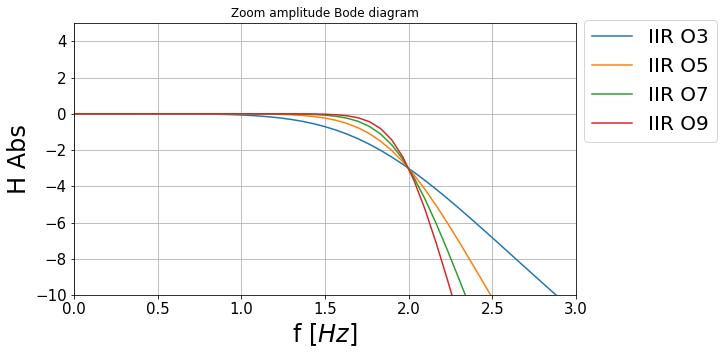

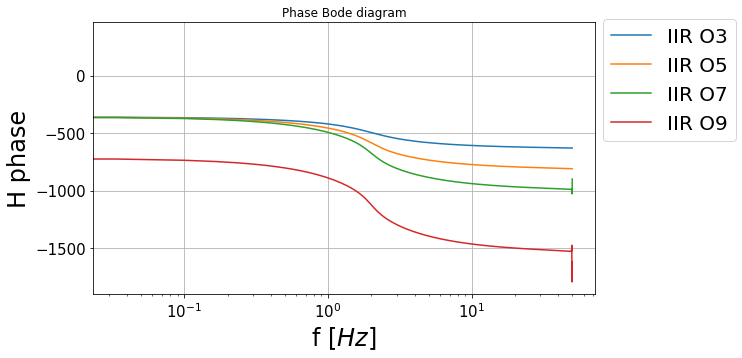

In [11]:
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(w3/np.pi*fs/2,mag3,label='IIR O3')
plt.plot(w3/np.pi*fs/2,mag5,label='IIR O5')
plt.plot(w3/np.pi*fs/2,mag7,label='IIR O7')
plt.plot(w3/np.pi*fs/2,mag9,label='IIR O9')
plt.legend(fontsize=20)
plt.xlabel('f $[Hz]$',fontsize=24)
plt.ylabel('H Abs',fontsize=24)
plt.title('Zoom amplitude Bode diagram')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor=(1.3, 1.05), fontsize=20)   
plt.xlim([0,3])
plt.ylim([-10,5])
plt.grid()
plt.show()
    
    
fig, ax = plt.subplots(figsize=(9,5)) 
plt.semilogx(w3/np.pi*fs/2,phase3,label='IIR O3')
plt.semilogx(w3/np.pi*fs/2,phase5,label='IIR O5')
plt.semilogx(w3/np.pi*fs/2,phase7,label='IIR O7')
plt.semilogx(w3/np.pi*fs/2,phase9,label='IIR O9')
plt.legend(fontsize=20)
plt.xlabel('f $[Hz]$',fontsize=24)
plt.ylabel('H phase',fontsize=24)
plt.title('Phase Bode diagram')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor=(1.3, 1.05), fontsize=20)     
plt.grid()
plt.show()

`````{admonition} Tip
:class: tip
The $\textit{padlen}$ argument of the $\textit{filtfilt}$ function is set to 300 to solve boundary condition problems
`````

In [12]:
y_filt_filt_O3=signal.filtfilt(b3,a3,y, padlen=300)
y_filt_filt_O5=signal.filtfilt(b5,a5,y, padlen=300)
y_filt_filt_O7=signal.filtfilt(b7,a7,y, padlen=300)
y_filt_filt_O9=signal.filtfilt(b9,a9,y, padlen=300)

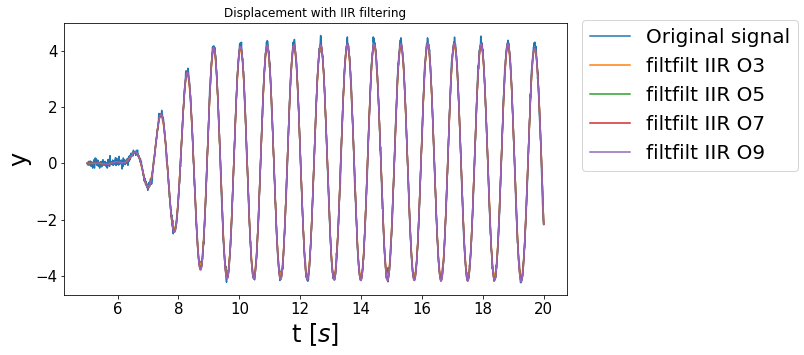

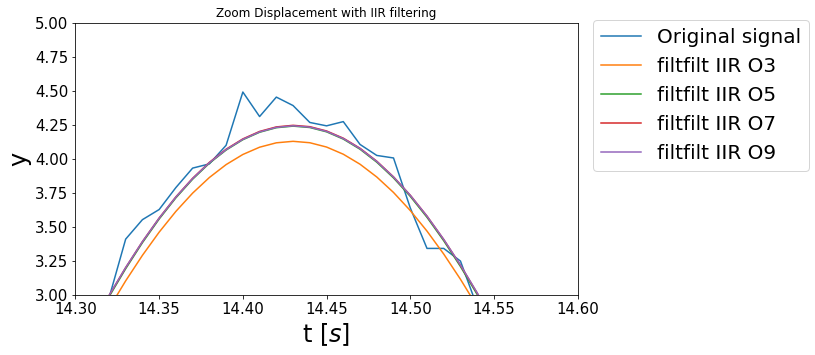

In [13]:
fig, ax = plt.subplots(figsize=(9,5)) 
plt.plot(x,y,label='Original signal')
plt.plot(x,y_filt_filt_O3,label='filtfilt IIR O3')
plt.plot(x,y_filt_filt_O5,label='filtfilt IIR O5')
plt.plot(x,y_filt_filt_O7,label='filtfilt IIR O7')
plt.plot(x,y_filt_filt_O9,label='filtfilt IIR O9')
plt.legend(fontsize=20)
plt.xlabel('t $[s]$',fontsize=24)
plt.ylabel('y',fontsize=24)
plt.title('Displacement with IIR filtering')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor=(1.01, 1.05), fontsize=20)       
plt.show()

fig, ax = plt.subplots(figsize=(9,5)) 
plt.plot(x,y,label='Original signal')
plt.plot(x,y_filt_filt_O3,label='filtfilt IIR O3')
plt.plot(x,y_filt_filt_O5,label='filtfilt IIR O5')
plt.plot(x,y_filt_filt_O7,label='filtfilt IIR O7')
plt.plot(x,y_filt_filt_O9,label='filtfilt IIR O9')
plt.legend(fontsize=20)
plt.xlabel('t $[s]$',fontsize=24)
plt.ylabel('y',fontsize=24)
plt.xlim([14.3, 14.6])
plt.ylim([3, 5])
plt.title('Zoom Displacement with IIR filtering')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor=(1.48, 1.05), fontsize=20)         
plt.show()

The original signal filtered with IIR filters of order 5,7,9 leads to almost indistinguishable lines. <br>
The filter of order 5 is chosen because the bode diagrams show no signs of oscillations

## Comparison IIR and FIR filtering

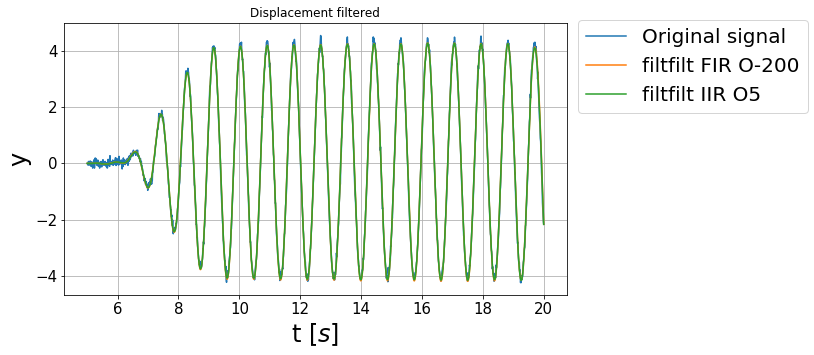

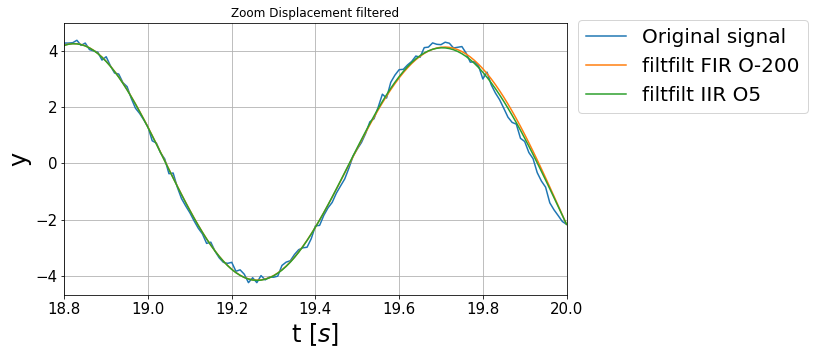

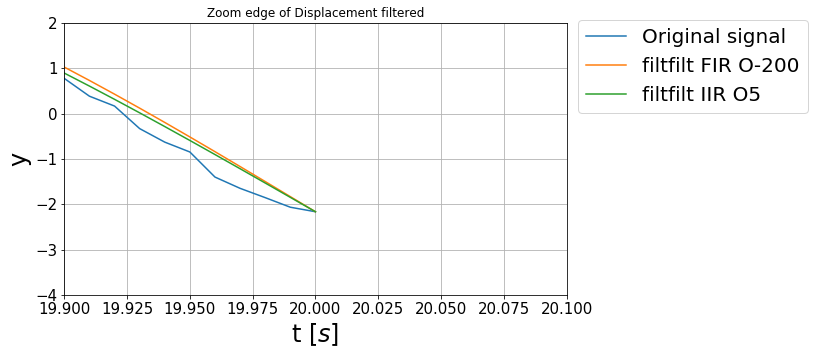

In [14]:
fig, ax = plt.subplots(figsize=(9,5)) 
plt.plot(x,y,label='Original signal')
plt.plot(x,y_filt_filt_200,label='filtfilt FIR O-200')
plt.plot(x,y_filt_filt_O5,label='filtfilt IIR O5')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('t $[s]$',fontsize=24)
plt.ylabel('y',fontsize=24)
plt.grid()
plt.title('Displacement filtered')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor=(1.5, 1.05), fontsize=20)      
plt.show()

fig, ax = plt.subplots(figsize=(9,5)) 
plt.plot(x,y,label='Original signal')
plt.plot(x,y_filt_filt_200,label='filtfilt FIR O-200')
plt.plot(x,y_filt_filt_O5,label='filtfilt IIR O5')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('t $[s]$',fontsize=24)
plt.ylabel('y',fontsize=24)
# plt.xlim([14.3, 14.6])
# plt.ylim([3, 5])
plt.xlim([18.8, 20])
# plt.ylim([3, 5])
plt.grid()
plt.title('Zoom Displacement filtered')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor=(1.5, 1.05), fontsize=20)      
plt.show()

fig, ax = plt.subplots(figsize=(9,5)) 
plt.plot(x,y,label='Original signal')
plt.plot(x,y_filt_filt_200,label='filtfilt FIR O-200')
plt.plot(x,y_filt_filt_O5,label='filtfilt IIR O5')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('t $[s]$',fontsize=24)
plt.ylabel('y',fontsize=24)
plt.xlim([19.9, 20.1])
plt.ylim([-4, 2])
plt.grid()
plt.title('Zoom edge of Displacement filtered')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor=(1.5, 1.05), fontsize=20)       
plt.show()

The main challenges in constructing a filter are many. <br>
* $\textbf{The choice of cut-off frequency.}$ <br>
In order not to risk decreasing the amplitude of the signal of interest, one might consider moving the cut-off frequency further away from the frequency of interest. This would entail accepting that more noisy frequencies remain unattenuated in the signal. <br>
* $\textbf{The choice of filter order:}$ <br>
In both cases, IIR and FIR, a higher order filter leads to a higher phase delay (in the case of IIR also to the presence of oscillations) but also to a higher filter slope near the cut-off frequency. <br>
* $\textbf{The problem of dealing with boundary conditions:}$ <br>
A causal approach (recursive (FIR or IIR) or zero-padding+convolution (FIR)) leads to phase delay and boundary problems for the first instants of the signal. A non-causal approach (convolution (FIR)) eliminates the phase delay problem but brings boundary problems to the final instants of the signal. <br>
In this case, the filtfilt function was adopted, which after mirroring the signal applies a recursive formula successively in one direction and in the other to eliminate the phase delay. Then the signal is truncated to the initial length to eliminate the boundary problems.